<a href="https://colab.research.google.com/github/ericcj24/DL4H/blob/main/DL4H_Team_134.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Electrocardiogram (ECG) is a quick test to detect heart beat, it records electric signals of the heart. The result of the measurement help detect irregular heart beat.[9]

*   ECG data is produced by various real time monitoring device types manufactured with a wide range of accuracies and noise levels, the primary issues for ECG Classification through traditional DNN methods are -
  * The rare occurrence of anomalies in continuous ECG data leads to Class imbalance
  * Low signal quality arising due to low sampling frequency.
  * Human experts are required to annotate the sample to achieve acceptable accuracy, this expert interaction is an expensive activity.

The third limitation is the one this paper targets to solve by applying the specific approach described below. Alternative approaches exist to handle this limitation like Active Learning and semi-supervised learning but the primary method we will be working on is Transfer learning.
  
  ## What did the paper propose? What is the innovations of the method


This paper use Transfer Learning techniques to pretrain the large amount of publicly available raw ECG data in Icentia11K [2] (labeled and unlabeled samples are used as part of pre training tasks) and transfer the weights from the model as an input to CNN which will then use this input to finetune the model and will try to classify Atrial Fibrillation (AF, this is a severe type of heart arrhythmia) on PhysioNet/CinC 2017 input data set [3][4].

The concept of Transfer Learning is applied extensively in computer vision for classification algorithms; this relies on the theory that knowledge extracted from a large dataset can be applied in a similar domain to improve the model performance for a completely different kind of classification. This paper pretrains the data for heart failure classification, using the weights as starting point, instead of random weights initialization, to obtain a more accurate AF classification on smaller target dataset in PhysioNet/CinC 2017 data set [3][4].

  # How well the proposed method work (in its own metrics)?
  The paper indicates an improvement of 6.5% in related ECG classification when model is pretrained on a large dataset.
  


# Scope of Reproducibility:

List hypotheses from the paper we will test and the corresponding experiments we will run.

We have constructed following hypothesis:

1.   Hypothesis 1: Beat, Rhythm and Heart Rate classification pre-training methods will have better macro F1 score than the random weights initialization methods when dealing with ECG classification problem.
2.   Hypothesis 2: Pre-training will improve the training times in addition to increase in performance when compared to random weights initialization.
3.   Hypothesis 3: Pretraining allows models to be trained on less data and still achieve the same degree of performance as the same models that are not pretrained.
4.   Hypothesis 4: Future predictions will work with acceptable accuracy when using pre-trained models on downstream datasets like PTB-XL database [5] for a related ECG classification.

We will device following experiments to test above hypthesis:

1. In experiment 1, We will pre-train the model on Icentia dataset, then transfer the weights for downstream fine-tuning model (model 1), we will separately train a model with weight that is randomly initialiazed (model 2), we will verify our hypothesis 1 that model 1 should have better f1 score.

2. During experiment 1, we will record the epoch used in training both models, and test hypothesis 2 by observing which model performs better with same training epoch.

3. During experiment 1, we will record the volume of data used in training both models, and test hypothesis 3, by observing the performance difference of the models when data volume used in testing are the same.

4. We will proceed to use PTB-XL database to fine-tune the model, and record downstream model (model 3) performance on hold-out dataset.

# Out of Scope
1. The paper also illustrates the future prediction based on attention model based transformer archietecture, due to sheer scale of work involved, we anticipate we will not be able to test this pretraining hypothesis as part of this paper. We nonetheless try to provide a brief analysis on Model architecture and report on our understanding of the underlying principle of Contrastive Predictive Coding[6].
2. One of the paper experiments deals with experimenting with training on ResNet50 and other model parameters like filter size, we will not be able to record the observations for this part of the experiment due to computation and time constraints.



In [ ]:
# Our Notebook is available on github here: https://github.com/ericcj24/DL4H
# Unfortunately the auxiallry files were too big for github, ie excess of 100MB
# So we are sharing them through Google Drive.

## Packages and Dependencies
Below we setup the packages needed, and upgrade some packages so that there is no conflict among dependencies.

In [ ]:
# we need gdown to pull down model files, and images required by this notebook
import sys
name = 'gdown'
if not name in sys.modules:
  print("installing gdown")
  !pip install --upgrade gdown

import gdown

installing gdown


In [ ]:

# Below we install some package required for the orignal paper git repo code (repo code).
# One thing we noticed is the repo code has a dependency on samplerate, which requires cmake to build.
# For some stange reason pip would complain cmake not existing despite the opposite.
# We found a solution by unstall cmake first, then install samplerate. This resolves the issue.
# Separately, we also need to install another dependency wfdb, which runs smoothly.

#Execution code commented, since this is required only first time.

# step 1
!pip uninstall --verbose cmake
# step 2
if not "samplerate" in sys.modules:
  print("installing samplerate")
  !pip install --verbose samplerate
# step 3
if not "wfdb" in sys.modules:
  print("installing wfdb")
  !pip install --verbose wfdb
# upgrade keras
!pip install --upgrade keras
# upgrade tensorflow to 2.16
!pip install --upgrade tensorflow

# not used: update torch summary, maybe to print model dimension?
#!pip install --verbose torchsummary


# !pip install h5py
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install scipy
# !pip install tqdm

Some key packages are documented in the following cell:

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
import samplerate

#%tensorflow_version 2.14
print("tensorflow version: ")
print(tf.__version__)
print("\n keras version:")
print(keras.__version__)
print("\n python version:")
print(sys.version)


tensorflow version: 
2.15.0

 keras version:
3.3.3

 python version:
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


## Files
Because gitlab can't host large files, like datasets used in training model. We've hosted the original paper code (downloaded from github), model training data, model weight files (trained on local machine), and images used in this notebook all on Google Drive.


*   We have compressed those files in two files, and stored them on the Google Drive.
*   We are using gdown to pull down, and unzip them.
*   We are also adjusting the original paper code's directory so that they could be picked up by notebook.
*   With files hosted on Google Drive, each file is assgined a unique id, when using gdown, we just need to reference the id to download the specific file.



In [ ]:
# Important note - we plan to use the code provided by authors here- https://github.com/kweimann/ecg-transfer-learning/tree/master
# we will import the necessary code to display the model, data set statistics and experiments specified in the paper.

In [ ]:
# download all content needed for this notebook: pictures, model weights, and original paper repo code

id = "1kAxUyPl7sf42w2T18iXdZZ2915T-V6an"
gdown.download(id = id, output="dl4h_model.tar.gz")
!tar -xf dl4h_model.tar.gz

# data
id = "1LIS7Iabz_V-kiQE4Nnswbfg5yf4U6Jur"
gdown.download(id = id, output="data.tar.gz")
!tar -xf data.tar.gz


In [ ]:
# we need to adjust the directory by moving original paper repo code up a level
!mv "/content/dl4h_model/pretraining" "/content/"
!mv "/content/dl4h_model/transplant" "/content/"
!mv "/content/dl4h_model/finetuning" "/content/"
print("\n content of pretraining:")
!ls "/content/pretraining/"
print("\n content of transplant:")
!ls "/content/transplant/"
print("\n content of finetuning:")
!ls "/content/finetuning/"


 content of pretraining:
datasets.py  __init__.py  __pycache__  README.md  trainer.py  utils.py

 content of transplant:
datasets  evaluation.py  __init__.py  modules  __pycache__  tasks  utils.py

 content of finetuning:
adjust_network.py  datasets.py	__init__.py  __pycache__  README.md  trainer.py  utils.py


In [ ]:
print(" files in content folder: ")
!ls "/content/"
print("\n files in dl4h_model folder: ")
!ls "/content/dl4h_model/"
print("\n files in data folder: ")
!ls "/content/data"
print("\n files in dl4h_model/mod_jobs folder: ")
!ls "/content/dl4h_model/mod_jobs/"

# content are organized as:
# /content/
#         data/
#             physionet/
#             physionet_test.pkl
#             physionet_train.pkl
#             ptbxl_test.pkl
#             ptbxl_train.pkl
#         dl4h_model/
#             mod_jobs/
#                 af_classification/
#                 hr_classification/
#                 rhythm_classification/
#                 beat_classification/
#                 ptbxl_classification/
#                 beat_random_classification/
#                 ptbxl_random_classification/
#             beat_classification/
#             transferlearning1.png
#         pretraining/
#         transplant/
#         finetuning/



 files in content folder: 
data	     dl4h_model		dl4h_model.tar.gzqwgg1ulktmp  pretraining  transplant
data.tar.gz  dl4h_model.tar.gz	finetuning		      sample_data

 files in dl4h_model folder: 
beat_classification  mod_jobs  transferlearning1.png

 files in data folder: 
physionet  physionet_test.pkl  physionet_train.pkl  ptbxl_test.pkl  ptbxl_train.pkl

 files in dl4h_model/mod_jobs folder: 
af_classification    beat_random_classification  ptbxl_classification	      rhythm_classification
beat_classification  hr_classification		 ptbxl_random_classification


# Data

## Source of Input Data 1:
Publicly available Icentia11K [2], the dataset has size roughly 272GB.
Raw Dataset available at : https://academictorrents.com/details/af04abfe9a3c96b30e5dd029eb185e19a7055272


### Input Data Statistics 1

* No of Patients:       11000
* No of Labeled Beats:  2,774,054,987
* Sample Rate:          250 Hz
* Frame Size:           2049 Samples
* Segment Size:         1,048,577 Samples
* No of Frames:         1,084,314
* No of Segments:       542,157
* Dataset Size:         271.27 GB


## Source of Input Data 2
Publicly available PhysioNet [3], the dataset has size roughly
Data: https://doi.org/10.22489/CinC.2017.065-469




## Source of Input Data 3
PTB-XL database [5], and a dataset released in 1st China Physiological Signal Challenge 2018 [8]. In this production attempt, in the interest of brevity, we will explore with PTB-XL dataset, a dataset of size 1.8G in a zip file.
Data: https://pubmed.ncbi.nlm.nih.gov/32903191/

### Statistics of Input Data 3
* 21837 12-lead ECG recordings
* Sampled at 500 Hz
* Duration of each signal: 10 sec
* 3 categories: diagnostic, rhythm, and form (only rhythm used in this reproduction), result in sample of 21,066 samples
* The reproduction used 25% of the aforementioned sample

## Preparing of Datasets
The perparation of datasets (including splitting of train, validate, and test sets) is included as part of the train command. Please see Model Training section for details.

# Highlevel Model Structure


*   Here is the link to the paper: https://www.nature.com/articles/s41598-021-84374-8
*   Here is the link to the paper code repo: https://github.com/kweimann/ecg-transfer-learning/

*   The paper used Icentia11k dataset[2] for pretraining, Physionet dataset[3]for funetuning, and PTB dataset[5] for downstream tasks.
*   The paper started with a standard ResNet18 model, and pretraining it on Incentia11K dataset, then finetuning it on PhysioNet dataset, finally, on downstream task on PTBxl dataset.
*   For detail model structures, please see following sections on pretraining, and finetuning.


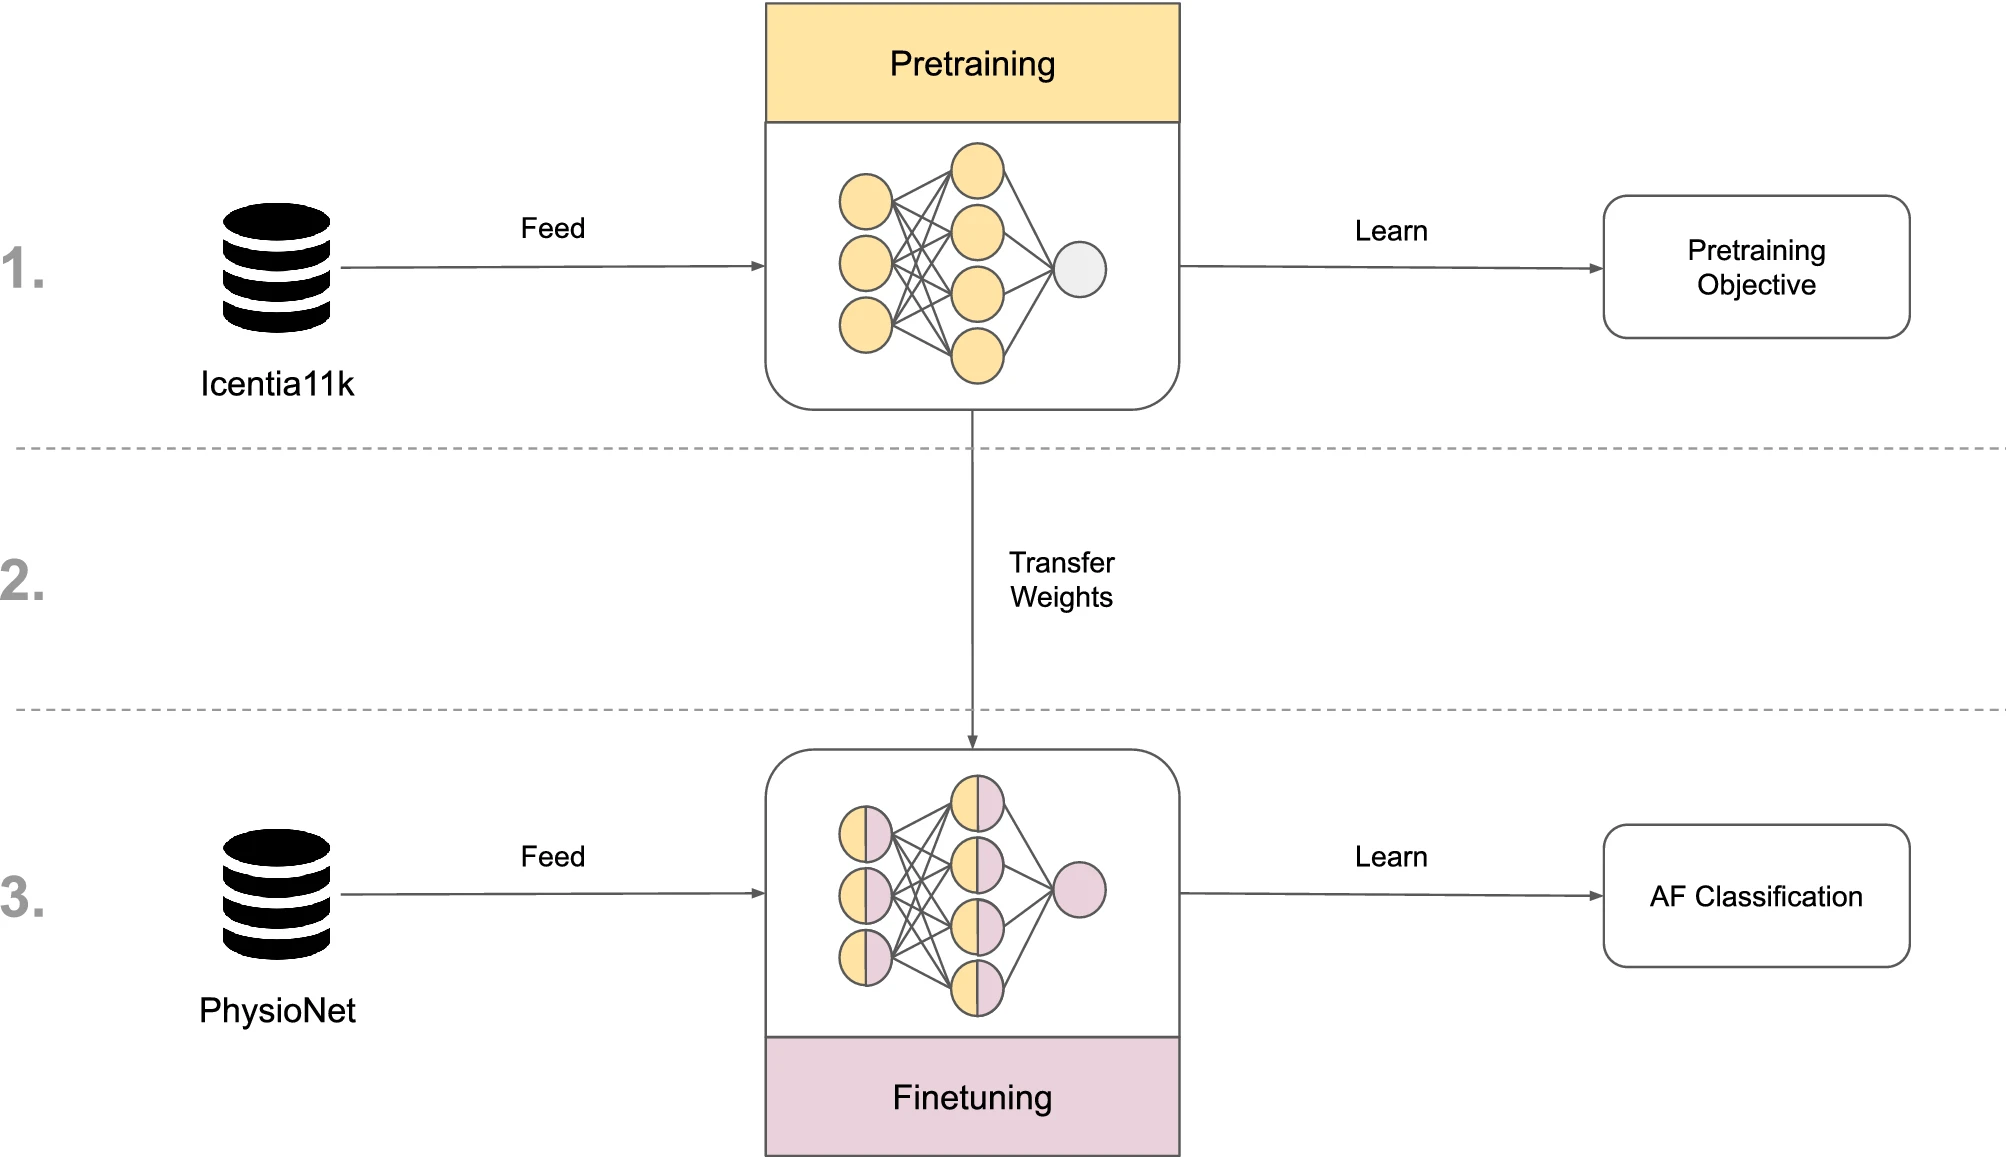

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# define dirs to workspace and data
img_dir = '/content/dl4h_model/transferlearning1.png'

img = cv2.imread(img_dir)

cv2_imshow(img)



# Methodology

The core parts of this paper involve the below steps.



1.   Step 1 - Pretraining residual CNN on large raw ECG data availabe in Icentia11k dataset[2], the dataset has size roughly 272GB.
2.   Step 2 - Finetuning the residual network for ECG classification for a smaller dataset PhysioNet/CinC 2017 data set [3][4] of size 1.4 GB.
3.   Step 3 - Use the pretrained model to implement ECG classification on a downstream dataset PTB-XL database [5] for related ECG classification in this case, heart beat classification.
4.   Step 4 - If time permits, Study the transformer architecture with attention model to check the future prediction of ECG frames to better use the economical unsupervisied mode for ECG classification.



#  Step 1 - PreTraining

Goal - DNN's will generalize better to unseen data after encountering wide variety of ECG signals during pretraining.







## Pretraining


Due to large size of input data, we have run the pretraining steps on on our local machine and uploaded the weights to google drive, we plan to use these pre-trained files for rest of our pipelines.

Following code cells are for illustration purpose.

### Preparing pretraining data
Feature Extraction and data processing for pretraining
1. Select random no of patients.
2. Collect mini batches by sampling short ECG frames(around 60 seconds)
3. Standardize each frame using meand and standard deviation of entire dataset, results in 4096 frames/ Patient.
4. Pretraining using both resNet18 and resNet34 architecture, the paper only uses single epoch but we have pretrained on 10 epochs.
5. Pick the best accuracy epoch for extracting weights, we will illustratate this from google drive jobs/beats_mulitple_epochs_classification/history.csv


In [ ]:
%%script false --no-raise-error
# preparing pretraining data for icentia11k dataset


!python -m pretraining.trainer \
--job-dir "dl4h_model/mod_jobs/beat_classification" \
--task "beat" \
--train "data/icentia11k_unzipped" \
--unzipped \
--arch "resnet18"


!python -m pretraining.trainer \
--job-dir "dl4h_model/mod_jobs/beat_classification" \
--task "beat" \
--train "data/icentia11k_unzipped" \
--unzipped \
--arch "resnet34"


In [ ]:
# Feature Extraction and data processing for pretraining
#.  1. Select random no of patients.
#   2. Collect mini batches by sampling short ECG frames(around 60 seconds)
#.  3. Standardize each frame using meand and standard deviation of entire dataset, results in 4096 frames/ Patient.
#   4. Pretraining using both resNet18 and resNet34 architecture,
       #the paper only uses single epoch but we have pretrained on 10 epochs.
#.  5. Pick the best accuracy epoch for extracting weights,
       #we will illustratate this from google drive jobs/<beats_mulitple_epochs-<34>_classification/history.csv>

df = pd.read_csv('dl4h_model/mod_jobs/hr_classification/history.csv')
df

,epoch,acc,loss,val_acc,val_loss
0,0,0.623299,0.857005,0.660422,0.810247
1,1,0.686317,0.732675,0.658080,0.794669
2,2,0.718999,0.669751,0.679157,0.757822
3,3,0.733385,0.634800,0.751756,0.709679
4,4,0.753714,0.595985,0.693208,0.789370
5,5,0.764816,0.579453,0.791569,0.646115
6,6,0.780923,0.553952,0.782201,0.702235
7,7,0.792181,0.532115,0.793911,0.674549
8,8,0.804848,0.497007,0.772834,0.622727
9,9,0.805473,0.490848,0.770492,0.725042


## Pre-train Model Selection
After running for 10 epochs, the best model is selected, its weights are saved in its correpond resnet model structure.

The following is for beat classification:

In [ ]:
%%script false --no-raise-error
# Beat Classification - Feature Extraction and data processing for pretraining
# from google drive jobs/<beats_mulitple_epochs-<34>_classification/history.csv>
# save the checkpoint weights for beat classification for resNet18 and resNet34

# Input Data: Short ECG Frame


# Classification class Labels : Normal,
                    #         : Premature Atrial Contraction,
                    #         : Premature Ventrical Contraction

from pretraining.utils import get_pretrained_weights


#Execution code commented since processing files are available in gdrive.


resnet18 = get_pretrained_weights(
    checkpoint_file='dl4h_model/mod_jobs/beat_multiple_epochs_classification/epoch_10_model.weights.h5',
    task='beat',
    arch='resnet18')
resnet18.save_weights('dl4h_model/mod_jobs/beat_classification/resnet18.weights.h5')



resnet34 = get_pretrained_weights(
    checkpoint_file='dl4h_model/mod_jobs/beat_multiple_epochs_34_classification/epoch_06_model.weights.h5',
    task='beat',
    arch='resnet34')
resnet34.save_weights('dl4h_model/mod_jobs/beat_classification/resnet34.weights.h5')

# The weights are already available in Google Drive
#resNet18 - dl4h_model/mod_jobs/beat_classification/resnet18.weights.h5
#resNet34 - dl4h_model/mod_jobs/beat_classification/resnet34.weights.h5



The following is for rhythem classification:

In [ ]:
%%script false --no-raise-error
# Rhythm Classification - Feature Extraction and data processing for pretraining
# from google drive jobs/<rhythm_mulitple_epochs-<34>_classification/history.csv>
# save the checkpoint weights for beat classification for resNet18 and resNet34

# Input Data: Short ECG Frame

# How is this measured? Duration of every rhythm to determine the label.


# Classification class Labels : Normal,
                    #         : Noise,
                    #         : Atrial Fibrillation AFlib
                    #         : Atrial Flutter AFlutter


#Execution code commented since processing files are available in gdrive.

resnet18 = get_pretrained_weights(
    checkpoint_file='dl4h_model/mod_jobs/rhythm_classification/epoch_01_model.weights.h5',
    task='rhythm',
    arch='resnet18')
resnet18.save_weights('dl4h_model/mod_jobs/rhythm_classification/resnet18.weights.h5')



resnet34 = get_pretrained_weights(
    checkpoint_file='dl4h_model/mod_jobs/rhythm_multiple_epochs_34_classification/epoch_10_model.weights.h5',
    task='rhythm',
    arch='resnet34')
resnet34.save_weights('dl4h_model/mod_jobs/rhythm_classification/resnet34.weights.h5')


# The weights are already available in Google Drive
# resNet18 - dl4h_model/mod_jobs/rhythm_classification/resnet18.weights.h5
# resNet34 - dl4h_model/mod_jobs/rhythm_classification/resnet34.weights.h5



Following are for heart rate classification:

In [ ]:
%%script false --no-raise-error
# Heart Rate Classification - Feature Extraction and data processing for pretraining
# from google drive jobs/<hr_mulitple_epochs-<34>_classification/history.csv>
# save the checkpoint weights for beat classification for resNet18 and resNet34

# What is measured? Estimate no of Beats/ Min

# How is this feature extracted?
#                     The labels are auto generated.
#                     find indices of heart beat using QRS Algorithm[35 in paper]
#                     Extend frame by 1 second at both ends.

# Input Data: Short ECG Frame

# Classification class Labels : Normal (60-100),
                    #         : Noise,
                    #         : Tachycardia (>100)
                    #         : Bradycardia (<60)


#Execution code commented since processing files are available in gdrive.


resnet18 = get_pretrained_weights(
    checkpoint_file='dl4h_model/mod_jobs/hr_classification/epoch_01_model.weights.h5',
    task='hr',
    arch='resnet18')
resnet18.save_weights('dl4h_model/mod_jobs/hr_classification/resnet18.weights.h5')



resnet34 = get_pretrained_weights(
    checkpoint_file='dl4h_model/mod_jobs/hr_multiple_epochs_34_classification/epoch_09_model.weights.h5',
    task='hr',
    arch='resnet34')
resnet34.save_weights('dl4h_model/mod_jobs/hr_classification/resnet34.weights.h5')


# The weights are already available in Google Drive
# resNet18 - dl4h_model/mod_jobs/hr_classification/resnet18.weights.h5
# resNet34 - dl4h_model/mod_jobs/hr_classification/resnet34.weights.h5

##   Model
The paper uses two main models.

1.   Residual Network CNN for pretraining and finetuning.
2.   Attention based transformer architecture for unsupervised learning.

The core claim and contribution of the paper deals with applying transfer learning from large datasets to accomplish ECG classifications on smaller datasets where the need for supervised labels is minimized. For this we only need to study the Residual network for both pretraining and finetuning modes.

We will pretrain our model on two architecture types resNet18 and resNet34, the computation and layers of resNet50 would be too complex to train and evaluate due to size of input dataset and compute capacity limitations.



TODO
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.



The paper proposes a Transfer Learning structure. It learns on large amount of data, but with less annotation, as a pretraining, then on a smaller, but better curated dataset, we transfer the weights learnt from the pre-training stage, and fine-tuned it for the downstream tasks.

For the pretraining phase, the paper uses a ResNet18 structure, trained on Icentia11K dataset.



In [ ]:
# Pretraining - Residual Network, ResNet18 considered as shallow network

#%run https://github.com/kweimann/ecg-transfer-learning/blob/master/finetuning/utils.py

# The core residual network comes from the well documented base network here[6] -
# He, K., Zhang, X., Ren, S., & Sun, J. Identity Mappings in Deep Residual Networks (2016). arXiv:1603.05027.


# The following modifications are made from the base Model
#. 1. Replace 2-d Convolution layers with 1-d counterparts for ECG data.
#  2. Larger filter sizes 7,5,5,3 at each stage instead of default size 3.
#


from transplant.modules.resnet1d import ResNet

stages=None
resnet_18 = ResNet(num_outputs=None,
                        blocks=(2, 2, 2, 2)[:stages],
                        kernel_size=(7, 5, 5, 3),
                        include_top=False)

input_shape = (1,1,64)
resnet_18.build(input_shape)
print(resnet_18.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'res_net_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "res_net_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_16 (ResidualBlock)    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_17 (ResidualBlock)    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_18 (ResidualBlock)    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_19 (ResidualBlock)    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_20 (ResidualBlock)    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_21 (ResidualBlock)    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_22 (ResidualBlock)    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_23 (ResidualBlock)    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# Step 2 - FineTuning Data and Model Section

## Input data:

Smaller target dataset for AF classification - PhysioNet/CinC 2017 data set [3][4].
Sample Rate:            300 Hz
Dataset Size:           1.4 GB
Test dataset available: No
Duration of Signal:     9-60 seconds.


## Data Split:
For the purpose of fine-tuning, the dataset has been splitted to 80/20 between training and testing.

## Target ECG classification
AF classification

## Location of dataset

physionet data is stored under data/physionet folder

In [ ]:
!ls data/physionet

In [ ]:
%%script false --no-raise-error
# Step 2 Finetuning

#Data preprocessing Steps:

# 1. Standardize signal using mean and standard deviation across the dataset.
# 2. Down Sampling from 300 to 250 Hz to match the Icentia11k dataset.
# 3. Pad some recording with zeros to have signal length of 60 seconds.
# 4. 75% training data, 20% Test and 5% validation splits with class balanced ratios.


from finetuning import datasets
from finetuning.utils import train_test_split
from transplant.utils import save_pkl

#Execution code commented due to resource constraint.

data = datasets.get_challenge17_data(
    db_dir='data/physionet',
    fs=250,  # keep sampling frequency the same as Icentia11k
    pad=16384,  # zero-pad recordings to keep the same length at about 65 seconds
    normalize=True)  # normalize each recording with mean and std computed over the entire dataset
# # maintain class ratio across both train and test sets by using the `stratify` argument
train_set, test_set = train_test_split(
    data, test_size=0.2, stratify=data['y'])
save_pkl('data/physionet_train.pkl', **train_set)
save_pkl('data/physionet_test.pkl', **test_set)



# Caution - The Above code is taking too long to upload and execute in colab,
#i have uploaded the files from local, it was executed with exact same code.
# My Drive/DL4H/data will have the two files data/physionet_train.pkl and
# data/physionet_test.pkl




In [ ]:
# Step 2 - FineTuning Model Modifications

#Pre - FineTuning Steps:


# Replace CNN output layer with Fully connected later with random weights,
# ensure the output matches the classes of finetuning dataset.

# FineTuning - Start

#Train CNN for upto 200 epochs, 50 epochs limit for accuracy metric improvement.
# If no imporvement for 50 epochs, stop training.

!python -m finetuning.trainer \
--job-dir "dl4h_model/mod_jobs/af_classification" \
--train "data/physionet_train.pkl" \
--test "data/physionet_test.pkl" \
--weights-file "dl4h_model/mod_jobs/beat_classification/resnet18.weights.h5" \
--val-size 0.0625 \
--arch "resnet18" \
--batch-size 64 \
--epochs 200

In [ ]:
# Record macro F1 Score.


# FineTuning - End.

# Revert weights of network to checkpoint at model at highest macro F1 score
# on Val set.


# Finally
from transplant.evaluation import f1
from transplant.utils import read_predictions


test = read_predictions('dl4h_model/mod_jobs/af_classification/test_predictions.csv')
y_true = test['y_true']
y_prob = test['y_prob']
print(f1(y_true, y_prob))

# Record macro F1 score on Test Set.

#end Finetuning

0.7361224341147975


## Finetuning with random initialized model weights
To demonstrate the difference of pre-trained model against random initialized model, by comparing their finetuning performance. We are finetuning again but with randomly intialized model.

In [ ]:
%%script false --no-raise-error
# finetuning with randomly initialized weights
# random intialized model for beat classification
!python -m finetuning.trainer \
--job-dir "dl4h_model/mod_jobs/beat_random_classification" \
--train "data/physionet_train.pkl" \
--test "data/physionet_test.pkl.pkl" \
--val-size 0.0625 \
--subset 0.25 \
--arch "resnet18" \
--batch-size 32 \
--epochs 200

# Step 3 - Downstream Dataset Classification

## Input Data Source:

 PTB-XL database [5]
 dataset of size 1.8G in a zip file.

## Traget Classification

Heart Beat Classification.


In [ ]:
%%script false --no-raise-error
# downstream task ptb dataset preparation
from finetuning import datasets
from finetuning.utils import train_test_split
from transplant.utils import save_pkl

data = datasets.get_ptb_xl_data(
  db_dir='data/ptbxl',
  fs=250,  # keep sampling frequency the same as Icentia11k
  pad=16384,  # zero-pad recordings to keep the same length at about 65 seconds
  normalize=True)  # normalize each recording with mean and std computed over the entire dataset
# maintain class ratio across both train and test sets by using the `stratify` argument
train_set, test_set = train_test_split(
  data, test_size=0.2)
save_pkl('data/ptbxl_train.pkl', **train_set)
save_pkl('data/ptbxl_test.pkl', **test_set)

The above code would split the ptb data into training and test sets.
The below code would finetune the resnet18 model on the downstream task of heart beat classification.

In [ ]:
# downstream task training
!python -m finetuning.trainer \
--job-dir "dl4h_model/mod_jobs/ptbxl_classification" \
--train "data/ptbxl_train.pkl" \
--test "data/ptbxl_test.pkl" \
--weights-file "dl4h_model/mod_jobs/hr_classification/resnet18.weights.h5" \
--val-size 0.0625 \
--subset 0.25 \
--arch "resnet18" \
--batch-size 32 \
--epochs 20


2024-05-04 22:21:04.830433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in dl4h_model/mod_jobs/ptbxl_classification
Setting random state 54003
Loading train data from data/ptbxl_train.pkl ...
^C


## Random Initialized Model
Here again we test with random intialized model on this downstream task, and compare the performance with pretrained model.

In [ ]:
%%script false --no-raise-error
# finetuning with randomly initialized weights
!python -m finetuning.trainer \
--job-dir "dl4h_model/mod_jobs/ptbxl_random_classification" \
--train "data/ptbxl_train.pkl" \
--test "data/ptbxl_test.pkl" \
--val-size 0.0625 \
--subset 0.25 \
--arch "resnet18" \
--batch-size 32 \
--epochs 20

## Hyperpamameters
During finetuning stage, batch size, subset, val-size, and architecture were used as hyperparameters

## Computation Requirement
We ran training on a local machine, here are its spec:


# Evaluate Pre Training methods

We have following pre training methods for evaluation



1.   Beat Classification
2.   Hr Classification
3.   Rhythm Classification.
4.   Stretch Goal - Future Prediction based on Transformer Architecture.

## Abalations Scope Evaluation



1.   Remove PreTraining and try ECG classification on af classification dataset, so random weights method. Please see Result section for the result from abalation study.
2.   Abalation study were conducted in two places: random initialized model were compared at beat classification task, and then at downstream classification using PTBxl dataset.


## Evaluation Code are shown in the Result section



# Results
We are not ready to include the results and analyses yet due to pending verification of downstream data sets and finetuning tasks for all modes of pretraining methods.

Once we complete the above activities we expect to fill the below table



In [ ]:
!ls "/content/dl4h_model/mod_jobs/rhythm_classification/"

##Beat classfication Result

In [ ]:
#Macro F1 Score and Accuracy are main metrics used and we plan to plot the results for specific pretraining method

#Pre Training Methods: beat_classification, rhythm_classification,
#                      hr_classification, random_weights_without_preTraining
#     if time permits, future_prediction_classification.

#Metrics Tracked: Macro F1 Score

#Dataset PhysioNet/CinC 2017 data set [3][4]

# Residual Network Architectures  : resNet18
#                                 : resNet34

test = read_predictions('dl4h_model/mod_jobs/beat_classification/test_predictions.csv')
y_true = test['y_true']
y_pred = test['y_prob']
print(f1(y_true, y_pred))

0.7363092239280914


In [ ]:
df = pd.read_csv('dl4h_model/mod_jobs/beat_classification/history.csv')
df

,epoch,acc,loss,val_acc,val_loss
0,0,0.622987,0.868146,0.637002,0.882434
1,1,0.679281,0.741296,0.653396,0.827100
2,2,0.715559,0.679665,0.702576,0.673229
3,3,0.739328,0.634544,0.679157,0.716463
4,4,0.734793,0.629174,0.702576,0.686063
...,...,...,...,...,...
68,68,0.991712,0.023615,0.840749,0.969767
69,69,0.998124,0.009095,0.822014,1.145243
70,70,0.999844,0.003642,0.831382,1.069000
71,71,1.000000,0.001712,0.831382,1.122057


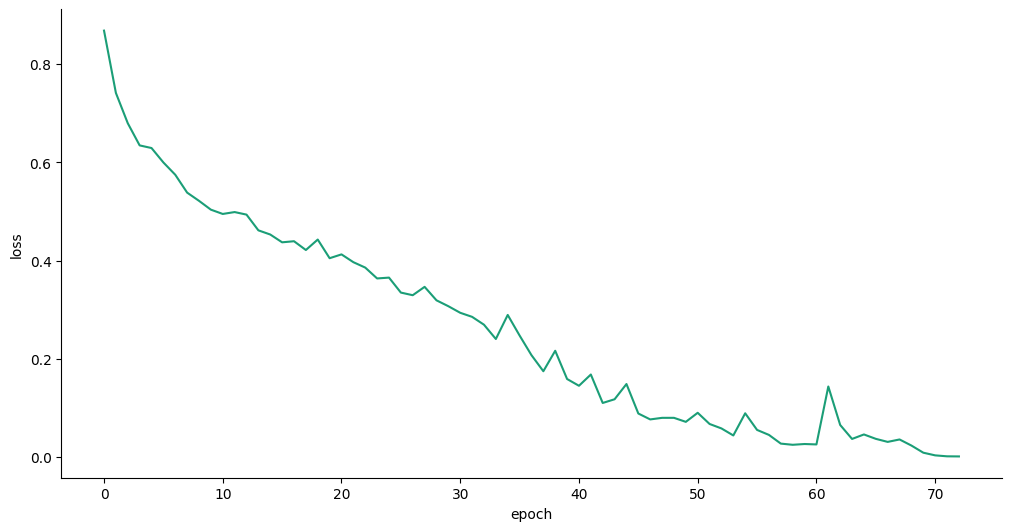

In [ ]:
# @title beat epoch vs loss

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

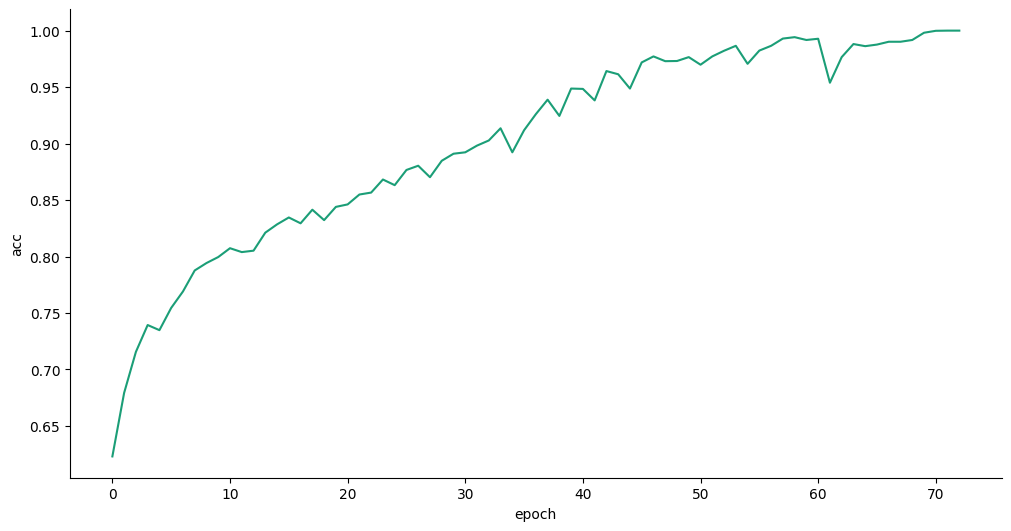

In [ ]:
# @title beat epoch vs acc

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['acc']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('acc')

## Beat Classification With Random Initialized Model Result

In [ ]:
test = read_predictions('dl4h_model/mod_jobs/beat_random_classification/test_predictions.csv')
y_true = test['y_true']
y_pred = test['y_prob']
f1_beat_random = f1(y_true, y_pred)


test = read_predictions('dl4h_model/mod_jobs/beat_classification/test_predictions.csv')
y_true = test['y_true']
y_pred = test['y_prob']
f1_beat = f1(y_true, y_pred)

data = [[f1_beat_random, f1_beat]]
pd.DataFrame(data, columns=["F1 Score random initialized model", "F1 Score pretrained model"])


,F1 Score random initialized model,F1 Score pretrained model
0,0.711082,0.736309


## Pretrained Model Performed Better Compared to Random Initialized Model
We can see pretrained model here achieved a higher F1 Score.

## AF Classification Result

In [ ]:
test = read_predictions('dl4h_model/mod_jobs/af_classification/test_predictions.csv')
y_true = test['y_true']
y_pred = test['y_prob']
print(f1(y_true, y_pred))

0.7361224341147975


In [ ]:
df = pd.read_csv('dl4h_model/mod_jobs/af_classification/history.csv')
df

,epoch,acc,loss,val_acc,val_loss
0,0,0.630023,0.870002,0.627635,0.850616
1,1,0.694449,0.723762,0.311475,1.523564
2,2,0.722283,0.665455,0.714286,0.654571
3,3,0.731353,0.636513,0.754098,0.611701
4,4,0.755434,0.604954,0.770492,0.615095
...,...,...,...,...,...
73,73,1.000000,0.000787,0.826698,1.096135
74,74,1.000000,0.000904,0.812646,1.216566
75,75,1.000000,0.000596,0.814988,1.179897
76,76,1.000000,0.000505,0.824356,1.157533


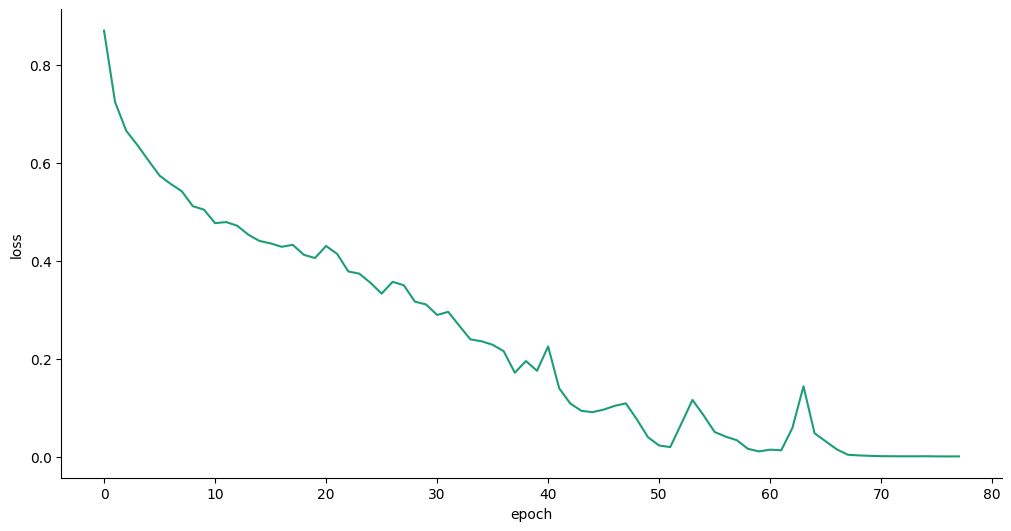

In [ ]:
# @title af epoch vs loss

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

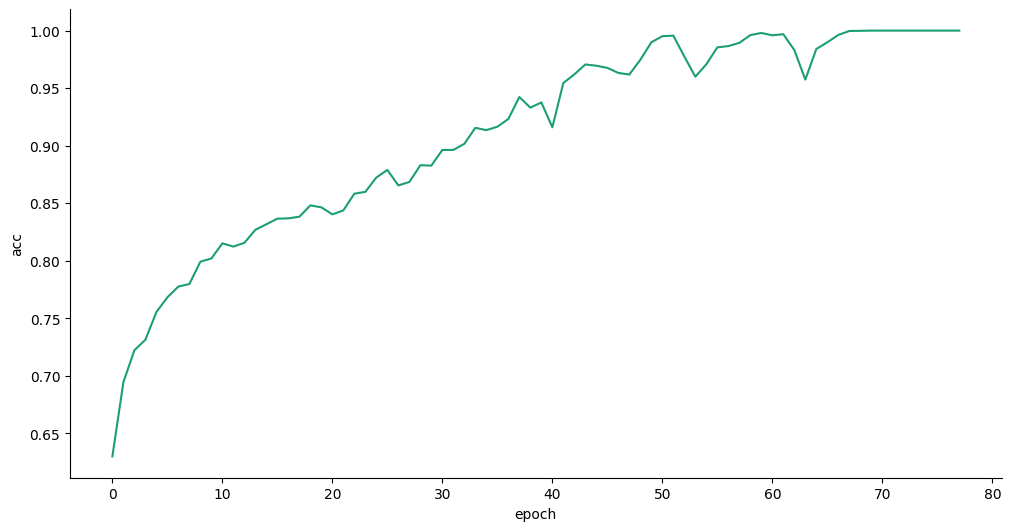

In [ ]:
# @title af epoch vs acc

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['acc']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('acc')

## Heart Beat Classification Result


In [ ]:
test = read_predictions('dl4h_model/mod_jobs/hr_classification/test_predictions.csv')
y_true = test['y_true']
y_pred = test['y_prob']
print(f1(y_true, y_pred))

0.7250877549790594


In [ ]:
df = pd.read_csv('dl4h_model/mod_jobs/hr_classification/history.csv')
df

,epoch,acc,loss,val_acc,val_loss
0,0,0.623299,0.857005,0.660422,0.810247
1,1,0.686317,0.732675,0.658080,0.794669
2,2,0.718999,0.669751,0.679157,0.757822
3,3,0.733385,0.634800,0.751756,0.709679
4,4,0.753714,0.595985,0.693208,0.789370
5,5,0.764816,0.579453,0.791569,0.646115
6,6,0.780923,0.553952,0.782201,0.702235
7,7,0.792181,0.532115,0.793911,0.674549
8,8,0.804848,0.497007,0.772834,0.622727
9,9,0.805473,0.490848,0.770492,0.725042


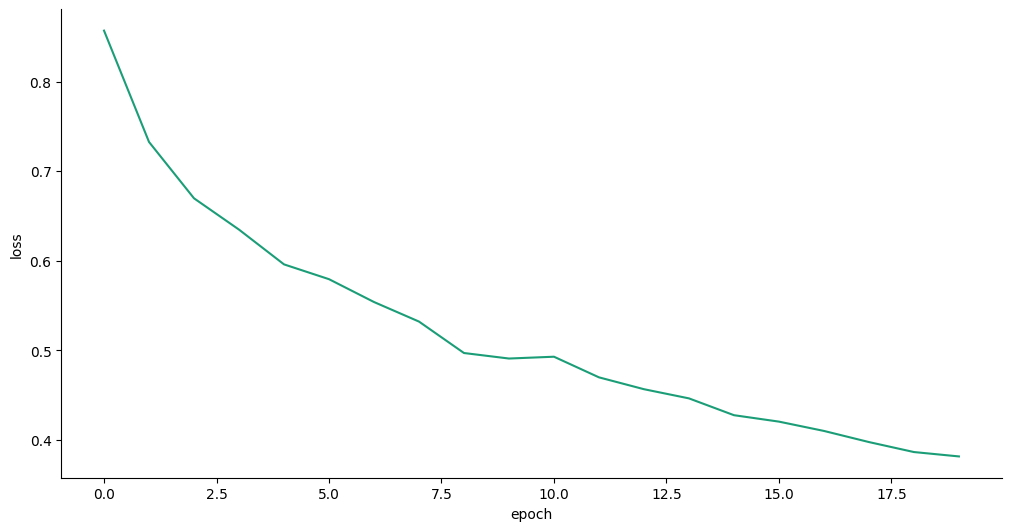

In [ ]:
# @title heart beat epoch vs loss

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

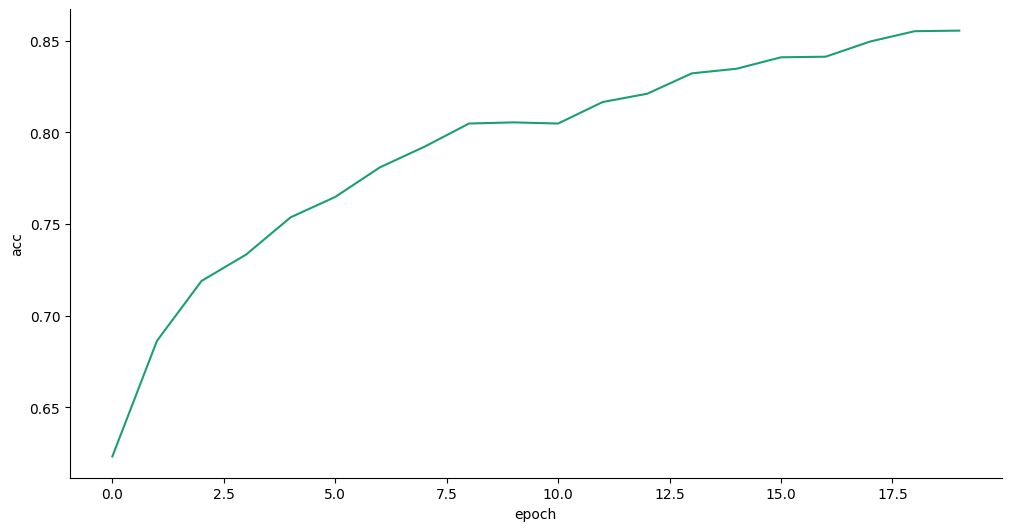

In [ ]:
# @title Heart Beat epoch vs acc

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['acc']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('acc')

## Rhythm Classification Result

In [ ]:
test = read_predictions('dl4h_model/mod_jobs/rhythm_classification/test_predictions.csv')
y_true = test['y_true']
y_pred = test['y_prob']
print(f1(y_true, y_pred))

0.7077099640846096


In [ ]:
df = pd.read_csv('dl4h_model/mod_jobs/rhythm_classification/history.csv')
df

,epoch,acc,loss,val_acc,val_loss
0,0,0.609539,0.912790,0.672131,0.763901
1,1,0.675840,0.752747,0.341920,1.668877
2,2,0.708991,0.688234,0.740047,0.687511
3,3,0.725098,0.660439,0.737705,0.627608
4,4,0.743081,0.627425,0.768150,0.556670
...,...,...,...,...,...
65,65,0.989523,0.032419,0.824356,0.831626
66,66,0.993432,0.022783,0.814988,0.808924
67,67,0.997498,0.011389,0.822014,0.895045
68,68,0.999218,0.005059,0.850117,0.853044


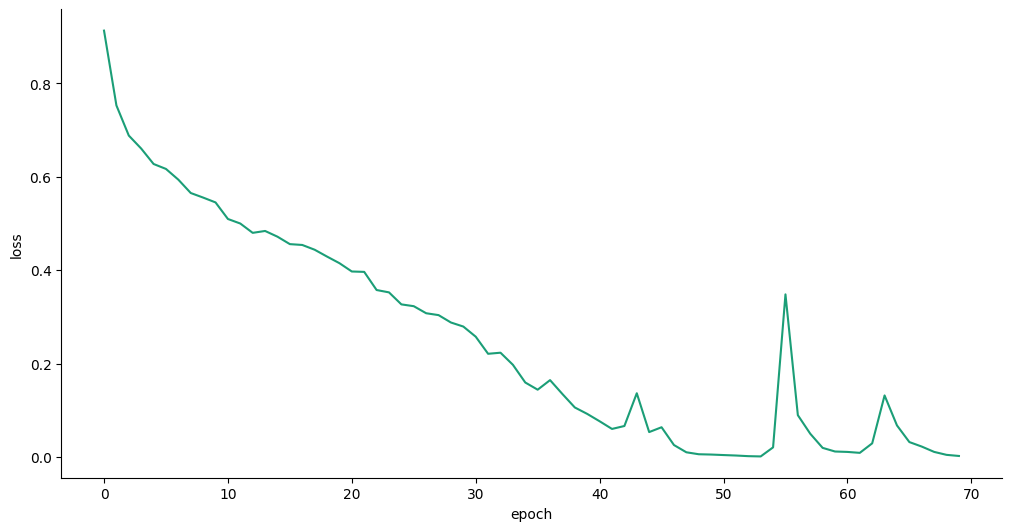

In [ ]:
# @title Rhythm Classification epoch vs loss

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

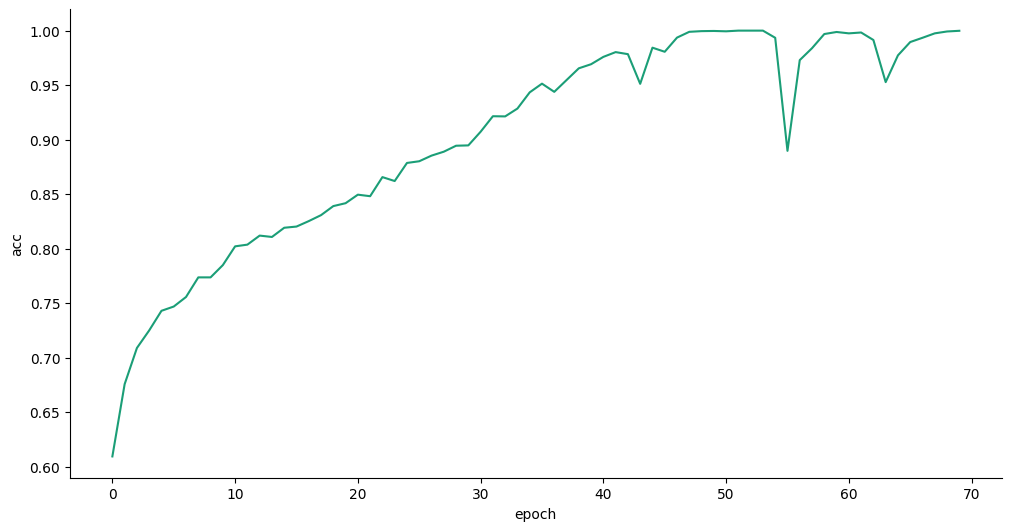

In [ ]:
# @title Rhythm Classification epoch vs acc

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['acc']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('acc')

##PTB-XL classification

In [ ]:
# datasets :  PTB-XL database [5]

from sklearn.metrics import roc_auc_score, f1_score


df = pd.read_csv('dl4h_model/mod_jobs/ptbxl_classification/history.csv')
df


,epoch,acc,loss,val_acc,val_loss
0,0,0.964579,0.106789,0.972513,0.083766
1,1,0.977492,0.070971,0.959838,0.114991
2,2,0.981043,0.061673,0.972354,0.091772
3,3,0.982818,0.057968,0.982889,0.062688
4,4,0.984170,0.054011,0.983682,0.054942
5,5,0.984931,0.051595,0.980672,0.067059
6,6,0.985755,0.049916,0.976632,0.074095
7,7,0.985882,0.049377,0.841730,0.962548
8,8,0.985798,0.048595,0.977899,0.074233
9,9,0.985734,0.048583,0.976473,0.072008


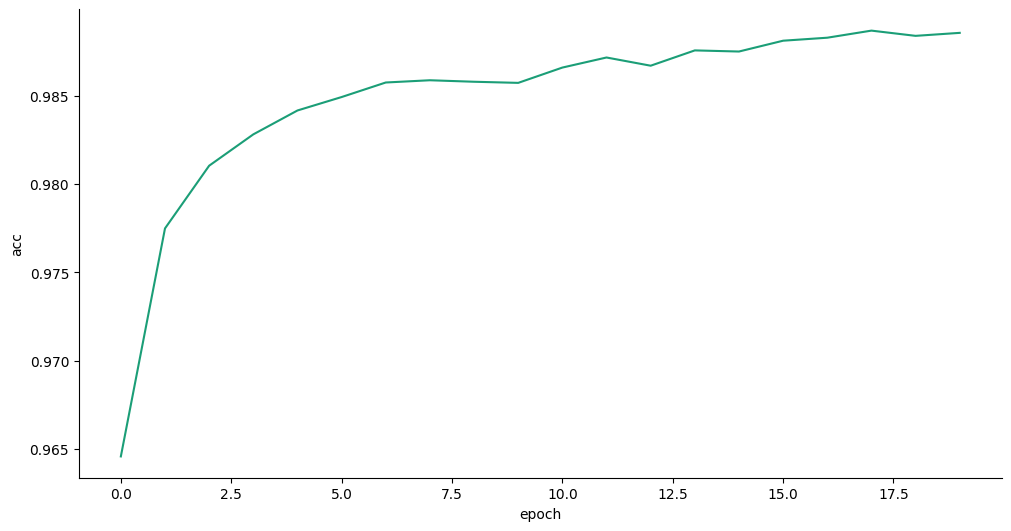

In [ ]:
# @title PTBxl epoch vs acc

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['acc']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('acc')

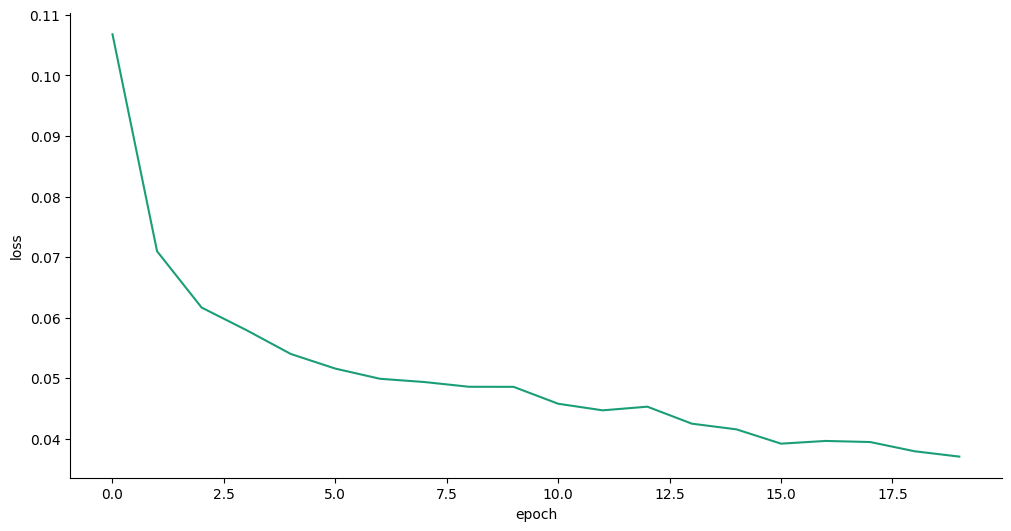

In [ ]:
# @title PTBxl epoch vs loss

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

In [ ]:
test = read_predictions('dl4h_model/mod_jobs/ptbxl_classification/test_predictions.csv')

y_true = test['y_true']
y_pred = test['y_prob']
print(f1(y_true, y_pred))


0.34088040135188563


## Random Initialized Model

In [ ]:
# datasets :  PTB-XL database [5]

from sklearn.metrics import roc_auc_score, f1_score


df = pd.read_csv('dl4h_model/mod_jobs/ptbxl_random_classification/history.csv')
df


,epoch,acc,loss,val_acc,val_loss
0,0,0.963691,0.113486,0.971404,0.089045
1,1,0.974786,0.078389,0.979959,0.069708
2,2,0.979035,0.068336,0.805450,0.893500
3,3,0.981655,0.062465,0.897893,0.250606
4,4,0.981676,0.060080,0.983048,0.058295
5,5,0.982374,0.059483,0.984949,0.054425
6,6,0.983177,0.058092,0.796737,1.554640
7,7,0.983050,0.056663,0.958096,0.121772
8,8,0.983938,0.054101,0.966651,0.091759
9,9,0.984255,0.052835,0.847671,0.920195


## Comparing Two Models on Downstream Task Trained on PTBxl Dataset
Comparing performances of pretrained model, and random intialized model, by comparing the acc at the end of 20 epoch, both model achieved a high accuracy.
By comparing F1 score, both model had a small score, with pretrained model slightly worse.



In [ ]:
from transplant.evaluation import f1
from transplant.utils import read_predictions
test = read_predictions('dl4h_model/mod_jobs/ptbxl_random_classification/test_predictions.csv')
y_true = test['y_true']
y_prob = test['y_prob']
f1_ptbxl_random = f1(y_true, y_prob)

df = pd.read_csv('dl4h_model/mod_jobs/ptbxl_random_classification/history.csv')
acc_ptbxl_random = df['acc'][df.shape[1]-1]


test = read_predictions('dl4h_model/mod_jobs/ptbxl_classification/test_predictions.csv')
y_true = test['y_true']
y_prob = test['y_prob']
f1_ptbxl = f1(y_true, y_prob)

df = pd.read_csv('dl4h_model/mod_jobs/ptbxl_classification/history.csv')
acc_ptbxl = df['acc'][df.shape[1]-1]


data = [[f1_ptbxl_random, f1_ptbxl], [acc_ptbxl_random, acc_ptbxl]]
df = pd.DataFrame(data, columns=["F1 Score random initialized model", "F1 Score pretrained model"])
df.index = ['f1', 'acc']
df

,F1 Score random initialized model,F1 Score pretrained model
f1,0.361706,0.34088
acc,0.981676,0.98417


## Future Prediction Model Discussion



1.   In case time permits, we plan to discuss our finding's on the auxillary experiment of the paper where in one of the pretraining methods a attention based transformer model is used to predict a future ECG frame based on current ECG frame and some context frames.
2.   During the study of this section we also plan to report on our understanding of Contrastive Predictive Coding from Computer vision space and how this principle was used for ECG data.





# Discussion


  ## Make assessment that the paper is reproducible or not.

Yes major part can be reproducible with code changes and restricted input datasets, we will not achieve the same improvements illustrated by authors but we will learn a lot in the process.

1.   The paper covers wide range of experiments and concepts to fit into final project reproduction, this when coupled with python, keras, tensorflow and cmake packages related dependencies in 2024, increases the challenge of reporducibility, the code needs an update.
2.   Key concepts(Transfer Learning, ECG signals, Attention models) and experiementation style(Architecture styles, different datasets in health care, study of various hyperparameters of residual networks) of authors are beneficial to us, so we could not reproduce the entire paper due to time constraints but time spent in understanding the paper was worthwhile.


  ## Describe “What was easy” and “What was difficult” during the reproduction.


1.   Easy Part - The well documented and modularized python code was easy to understand and we were able to make changes to make the pretraining, finetuning and downstream datasets work.
2.   Hard Part - The concept of ECG data and how we can gleen multiple information like Heart Rythm, beat in various sampling frequencies took lot of reading and experimentation to understand, the course focussed heavily on Image (X-ray) or EHR for explaining concepts, in retrospect we should have started early with understanding ECG data before we attempted the paper reproducibility.

3. Hard Part - The sheer scale of input data interms of ICENTIA11k, Physionet and PTBXL did not allow us to run the experiments in online colab notebook, we have to do the pretraining (225 GB data) , finetuning for PTBXL (when we take the entire dataset the GPU memory runs out and gives an error) in local machine and even then faced resource constraints, so we have to use subset of data for our experimentation.



  ## Make suggestions to the author or other reproducers on how to improve the reproducibility.
  

1.   The original code is based on tensorflow 2.1, it is way too old, the current version 2.16 of tensorflow needs minor code changes to make this reproducible. Other python packages like keras and cmake also caused issues with compatabile versions.
2.   Minor quibble - The reference section or readme can use notes on how the entire subset of ICENTIA11k and PTBXL data cannot be run on reasonabbly sized machines (i have 16 GB M1 Pro Macbook, still hit issues).
3.  ICENTiA11k - Data is 225 GB of compressed files, the pretraining tasks uses the subset of the data but the way it looks for the file is through random file name, if code can be changed to more greedy pull kind of approach, it would be easier to get away by downloading say 100 GB or even 1 GB of data, so that we can demonstrate the pretraining in online colab notebook.





# References

1. Weimann, K., Conrad, T.O.F. Transfer learning for ECG classification. Sci Rep 11, 5251 (2021). https://doi.org/10.1038/s41598-021-84374-8 https://github.com/kweimann/ecg-transfer-learning/tree/master

2. Tan, S. et al. Icentia11K: An Unsupervised Representation Learning Dataset for Arrhythmia Subtype Discovery (2019). arXiv:arXiv:1910.09570

3. Clifford, G. D. et al. AF Classification from a short single lead ECG recording: the PhysioNet/computing in cardiology challenge 2017. Comput. Cardiol. (2017).In 2017 Computing in Cardiology (CinC) 2017 Sep 24 (pp. 1-4). IEEE. https://doi.org/10.22489/CinC.2017.065-469

4. Goldberger, A. L. et al. PhysioBank, PhysioToolkit, and PhysioNet: components of a new research resource for complex physiologic signals. Circulation 101, e215–e220. https://doi.org/10.1161/01.CIR.101.23.e215 (2000).

5. Strodthoff, N., Wagner, P., Schaeffter, T., & Samek, W. Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL (2020). arXiv:2004.13701.

6. van den Oord, A., Li, Y., & Vinyals, O. Representation Learning with Contrastive Predictive Coding (2019). arXiv:1807.03748.

7. He, K., Zhang, X., Ren, S., & Sun, J. Deep Residual Learning for Image Recognition (2015). arXiv:1512.03385.

8. Liu, F. et al. An open access database for evaluating the algorithms of electrocardiogram rhythm and morphology abnormality detection. J. Med. Imaging Health Inf. 8, 1368–1373. https://doi.org/10.1166/jmihi.2018.2442 (2018).

9. Mayo Clinic Staff, Mayo Clinic in Rochester, Minnesota, Electrocardiogram (ECG or EKG), https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983

